In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from sklearn.preprocessing import normalize

In [140]:
# CCCNOT - the second way
dev = qml.device("default.qubit")
reg = qml.registers({"contol_wire": 3, "ancilla": 1, "target_wire":1})

def CCCNOT(arr):      
    qml.Toffoli([arr[0],arr[1],arr[3]])
    qml.Toffoli([arr[2],arr[3],arr[4]])

    # ancilla |1> -> |0>
    qml.Toffoli([arr[0],arr[1],arr[3]])

def CCCNOT_11(arr):
    qml.Toffoli([arr[0],arr[1],arr[3]])
    qml.Toffoli([arr[2],arr[3],arr[4]])
    qml.Toffoli([arr[2],arr[3],arr[5]])

    # ancilla |1> -> |0>
    qml.Toffoli([arr[0],arr[1],arr[3]])    

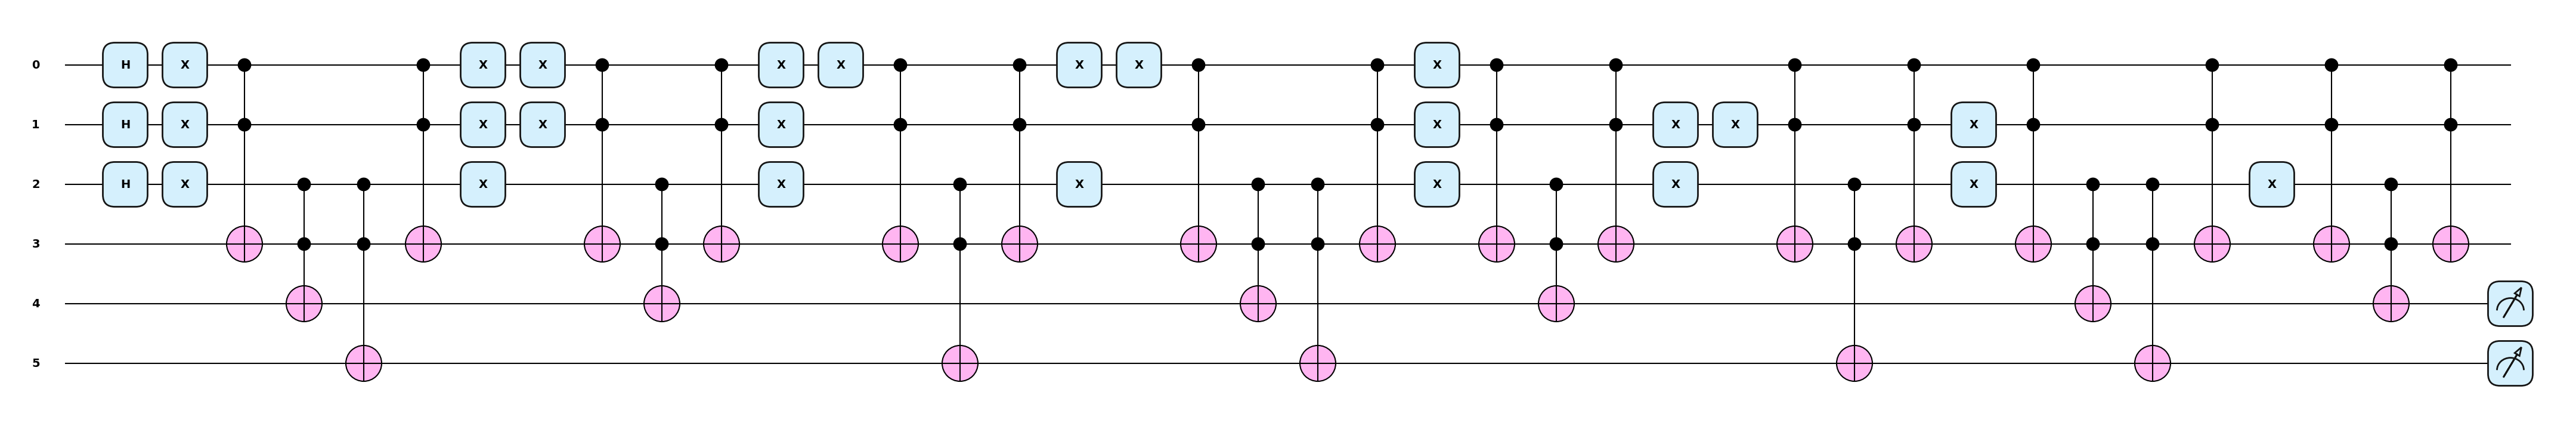

In [152]:
dev = qml.device('default.qubit')
reg = qml.registers({'idx_wire': 3, 'ancilla':1, 'val_wire': 2})

@qml.qnode(dev)
def qram():
    # index creation
    for idx in reg['idx_wire']:
        qml.Hadamard(idx)
    
    # |000>|11>
    for idx in reg['idx_wire']:
        qml.PauliX(idx)
    CCCNOT_11([0,1,2,3,4,5])
    for idx in reg['idx_wire']:
        qml.PauliX(idx)

    # |001>
    for idx in range(2):
        qml.PauliX(idx)
    CCCNOT([0,1,2,3,4])
    for idx in range(2):
        qml.PauliX(idx)

    # |010>
    for idx in [0,2]:
        qml.PauliX(idx)
    CCCNOT([0,1,2,3,5])
    for idx in [0,2]:
        qml.PauliX(idx)

    # |011>|11>
    qml.PauliX(0)
    CCCNOT_11([0,1,2,3,4,5])
    qml.PauliX(0)

    # |100>
    for idx in [1,2]:
        qml.PauliX(idx)
    CCCNOT([0,1,2,3,4])
    for idx in [1,2]:
        qml.PauliX(idx)

    # |101>
    qml.PauliX(1)
    CCCNOT([0,1,2,3,5])
    qml.PauliX(1)

    # |110>|11>
    qml.PauliX(2)
    CCCNOT_11([0,1,2,3,4,5])
    qml.PauliX(2)

    # |111>
    CCCNOT([0,1,2,3,4])
    
    return qml.density_matrix([4,5]) # extract value states

fig, _ = qml.draw_mpl(qram, style="pennylane", show_all_wires=True)()
plt.show()

In [153]:
qram()

array([[0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.25 +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.375+0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.375+0.j]])

In [178]:
len(qram().diagonal())

4

In [179]:
a = np.array(np.diag(np.ones(len(qram()))))
a = a.diagonal().reshape(1,-1)
a = normalize(a, norm='l2')
a.flatten()

array([0.5, 0.5, 0.5, 0.5])

In [244]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=6)

@qml.qnode(dev2)
def cswap():
    # input state
    coeff = np.sqrt(np.array([1/3,1/3,1/3]))
    base = np.array([[0,1],[1,0],[1,1]])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=3)
    # ref state
    qml.Hadamard(4)
    qml.Hadamard(5)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,4])
    qml.CSWAP([0,2,5])
    qml.Hadamard(0)

    qml.measure(0)
    qml.Barrier(range(6)) # probability measure
    
    qml.measure(3, reset=True)
    qml.measure(4, reset=True)
    qml.measure(5)
    # qml.WireCut(5)
    # qml.measure(5)
    return qml.probs([0])

cswap()

array([0.875, 0.125])

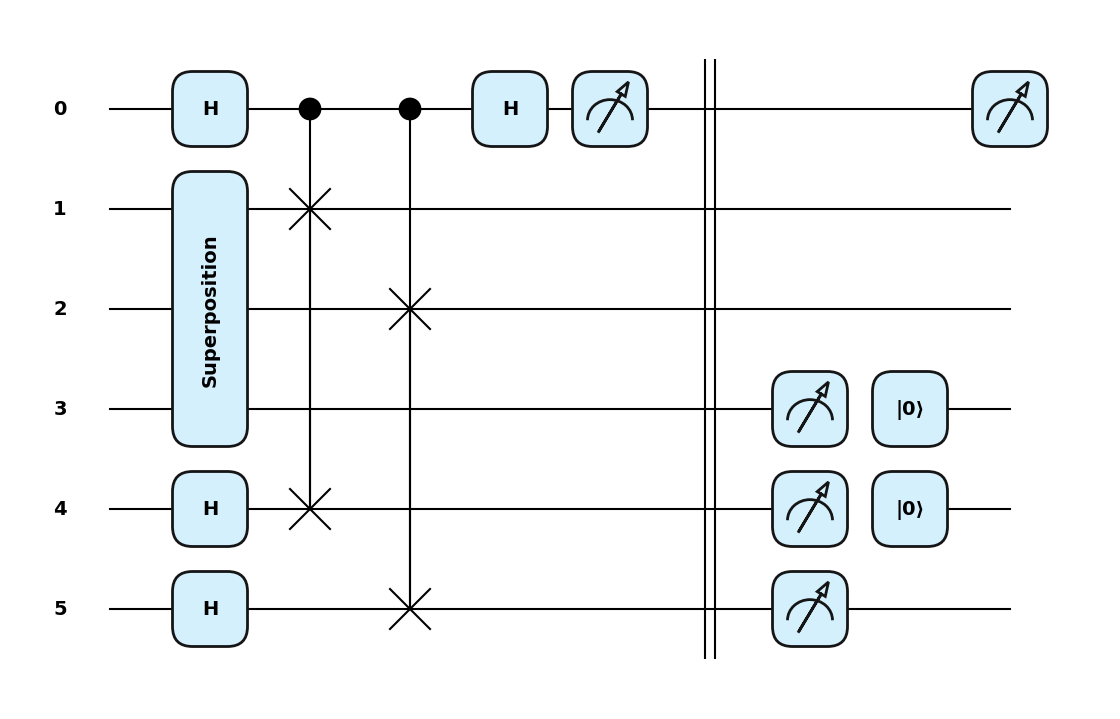

In [245]:
fig, _ = qml.draw_mpl(cswap, style="pennylane", show_all_wires=True)()

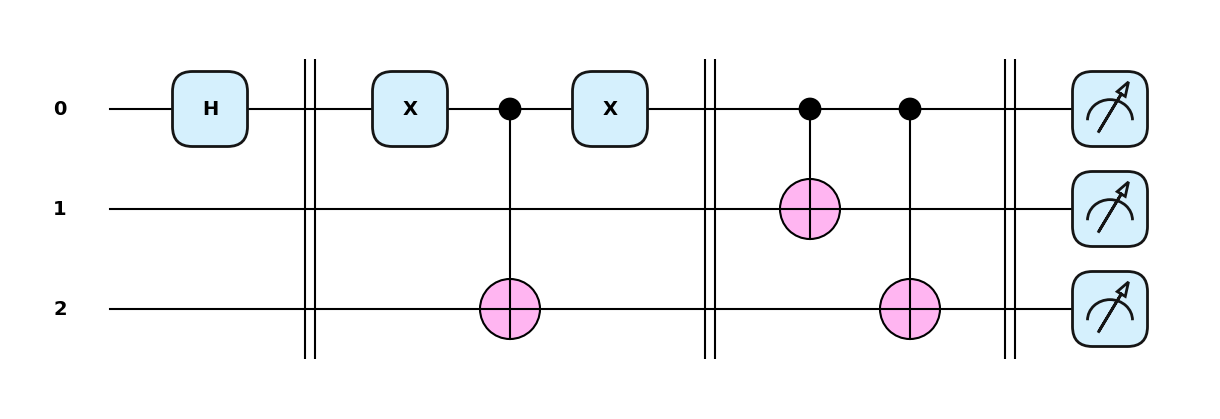

In [5]:
dev = qml.device('default.qubit')

@qml.qnode(dev)
def qram():
    # index creation
    qml.Hadamard(0)
    qml.Barrier(range(3))
    
    qml.PauliX(0)
    qml.CNOT([0,2])
    qml.PauliX(0)
    qml.Barrier(range(3))

    qml.CNOT([0,1])
    qml.CNOT([0,2])
    qml.Barrier(range(3))
    
    return qml.state()

fig, _ = qml.draw_mpl(qram, style="pennylane", show_all_wires=True)()
plt.show()

In [6]:
fig.savefig('qmemory_ex1.png')

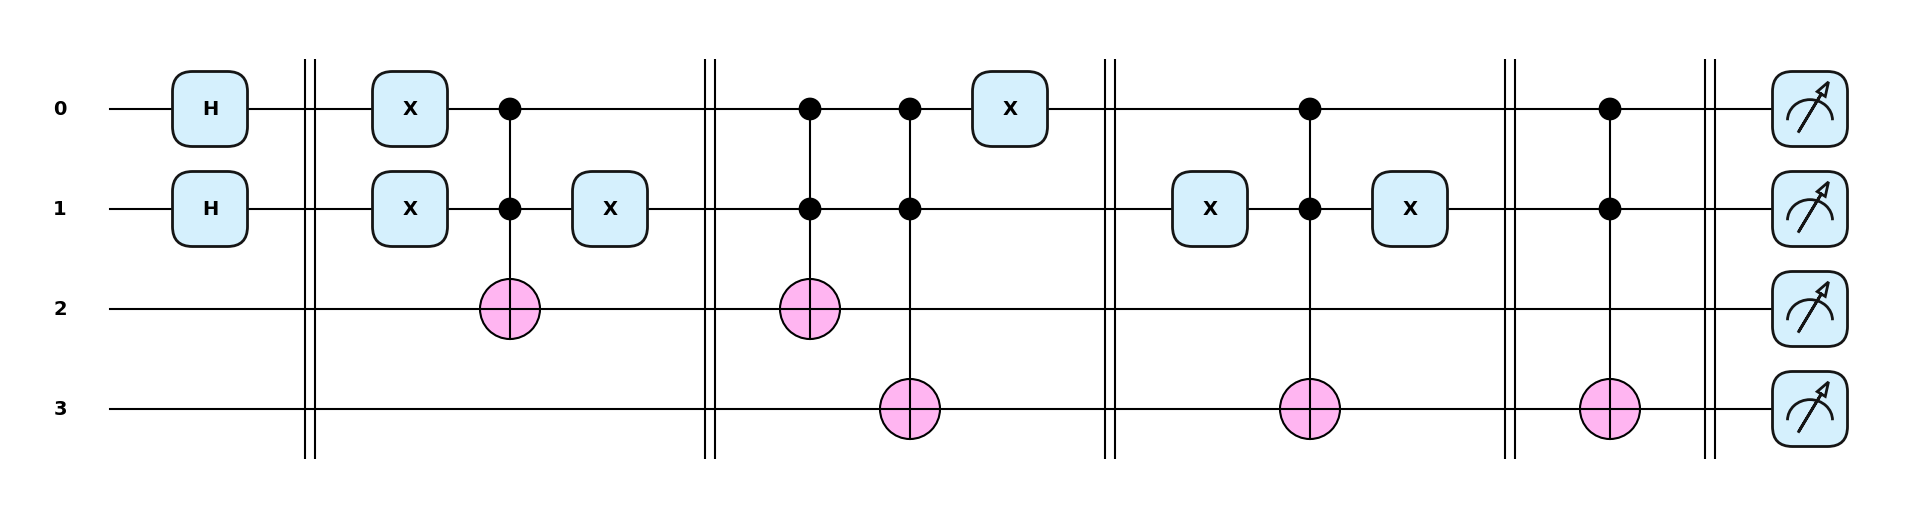

In [7]:
dev = qml.device('default.qubit')
reg = qml.registers({'idx_wire': 2, 'val_wire': 2})
        
@qml.qnode(dev)
def qram():
    # index creation
    for idx in reg['idx_wire']:
        qml.Hadamard(idx)
    qml.Barrier(range(4))

    # |00>|10>
    for idx in reg['idx_wire']:
        qml.PauliX(idx)
    qml.Toffoli([0,1,2])
    qml.PauliX(1)
    qml.Barrier(range(4))
    
    # |01>|10>
    qml.Toffoli([0,1,2])
    qml.Toffoli([0,1,3])
    qml.PauliX(0)
    qml.Barrier(range(4))

    # |10>|01>
    qml.PauliX(1)
    qml.Toffoli([0,1,3])
    qml.PauliX(1)
    qml.Barrier(range(4))
    
    # |11>|01>
    qml.Toffoli([0,1,3])
    qml.Barrier(range(4))
    
    return qml.state()

fig, _ = qml.draw_mpl(qram, style="pennylane", show_all_wires=True)()
plt.show()

In [8]:
fig.savefig('qmemory_ex2.png')